<a href="https://colab.research.google.com/github/KD08GG/IA/blob/main/Proyect2_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enviroment Implementation

In [ ]:
def random_obstacle() :
  import random
  x = random.randint(0, 9)
  #print(x)
  y = random.randint(0, 9)
  #print(y)
  if (x == 2 and y == 2 )or (x == 8 and y == 8) or (x==3 and y==3) or (x==5 and y==5) or (x== 1 and y== 1):
    random_obstacle()
  else:
    return (x,y)

In [ ]:
import gym
import numpy as np
from gym import spaces

class WarehouseEnv(gym.Env):
    def __init__(self, grid_size=10):
        super(WarehouseEnv, self).__init__()
        self.delivered_packages = 0  #Counter for delivered packages


        # Define grid size
        self.grid_size = grid_size

        #Random obstacle
        x_r, y_r = random_obstacle()
        print("Random obstacle generated at [", x_r,",", y_r, "]")

        # Warehouse configuration
        self.obstacles = {(3, 3), (5,5), (x_r,y_r)}
        self.pickup_point = (9, 4)
        self.delivery_point = (8, 8)

        # Actions
        self.action_space = spaces.Discrete(6)  # 0-3 (move), 4 (pick), 5 (deliver)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0]),
            high=np.array([grid_size - 1, grid_size - 1, 1, 100]),
            dtype=np.int32
        )

        # Reset to initial state
        self.reset()

    def reset(self):
        self.robot_pos = [1, 1]  # Initial position
        self.has_item = 0        #Item state (0 = doesnt have it, 1 = has it)
        self.energy = 100         # Initial energy
        #x_r, y_r = random_obstacle()
        #print("Reset Random obstacle generated at [", x_r,",", y_r, "]")
        return np.array(self.robot_pos + [self.has_item, self.energy])

    def step(self, action):

        # If energy is 0 end episode
        if self.energy == 0:
            return np.array(self.robot_pos + [self.has_item, self.energy]), -5, True, {}

        # Initial reward and done
        reward = -1  # Negative reward for moving
        done = False

        # Save last position
        prev_pos = self.robot_pos.copy()

        # If moving
        if action in {0, 1, 2, 3}:  # move actions
            self.move(action)

        # If it hits an obstable stay and receive negative points
        if tuple(self.robot_pos) in self.obstacles:
            self.robot_pos = prev_pos  # go to prior position
            reward = -10  # negative points

        elif action == 4:  # pick item
            if tuple(self.robot_pos) == self.pickup_point and self.has_item == 0:
                self.has_item = 1

        elif action == 5:  # deliver item
            if tuple(self.robot_pos) == self.delivery_point and self.has_item == 1:
                reward = 10
                self.has_item = 0  # drop package
                self.delivered_packages += 1  # increase counter

        self.energy -= 1
        if self.energy == 0:  # if energy is 0 then receive -5
            reward = -5
            done = True

        # return state, reward, done, info
        return np.array(self.robot_pos + [self.has_item, self.energy]), reward, done, {}

    def move(self, action):
        x, y = self.robot_pos

        if action == 0:  # up
            y = max(0, y - 1)
        elif action == 1:  # down
            y = min(self.grid_size - 1, y + 1)
        elif action == 2:  # left
            x = max(0, x - 1)
        elif action == 3:  # right
            x = min(self.grid_size - 1, x + 1)

        self.robot_pos = [x, y]  #move robot



## Agent Implementation

In [ ]:
import random
import numpy as np
from collections import defaultdict

class QLearningAgent:
    def __init__(self, env, alpha=0.99, gamma=0.8, epsilon=1.0, epsilon_decay=0.98, epsilon_min=0.01):
        self.env = env
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        self.alpha = alpha  # Tasa de aprendizaje
        self.gamma = gamma  # Factor de descuento
        self.epsilon = epsilon  # Probabilidad inicial de exploración
        self.epsilon_decay = epsilon_decay  # Factor de reducción de exploración
        self.epsilon_min = epsilon_min  # minimum epsilon

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Exploration
        else:
            return np.argmax(self.q_table[tuple(state)])  # Explotation

    def update_q_table(self, state, action, reward, next_state):
        old_value = self.q_table[tuple(state)][action]
        next_max = np.max(self.q_table[tuple(next_state)])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[tuple(state)][action] = new_value

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)



## Agent Trainning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

def render(self, ax, img):
    grid = np.zeros((self.grid_size, self.grid_size))  # empty matrix

    for obs in self.obstacles:
        grid[obs] = 1  # obstacles
    grid[self.pickup_point] = 2  # pickup point
    grid[self.delivery_point] = 3  # delivery point

    x, y = self.robot_pos
    grid[y, x] = 4 if self.has_item else 5  # Robot

    img.set_data(grid)
    plt.draw()
    plt.pause(0.3)


In [ ]:
env = WarehouseEnv()
agent = QLearningAgent(env)

episodes = 10000
rewards_per_episode = []
entregas_historial = []
trayectoria_ultimo_ep = [(1, 1)]

for episode in range(episodes):
    state = env.reset()
    total_reward = 100
    done = False
    env.delivered_packages = 0  # reset packages
    trayectoria_actual = [(1, 1)]

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)

        # save robots last position
        trayectoria_actual.append(tuple(env.robot_pos))

        agent.update_q_table(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        agent.update_epsilon()

    # save last episode
    if episode == episodes - 1:
        trayectoria_ultimo_ep = trayectoria_actual

    entregas_historial.append(env.delivered_packages)
    rewards_per_episode.append(total_reward)

env.trayectoria_ultimo_ep = trayectoria_ultimo_ep

print("Training complete.")


Random obstacle generated at [ 4 , 5 ]
Training complete.


## Results

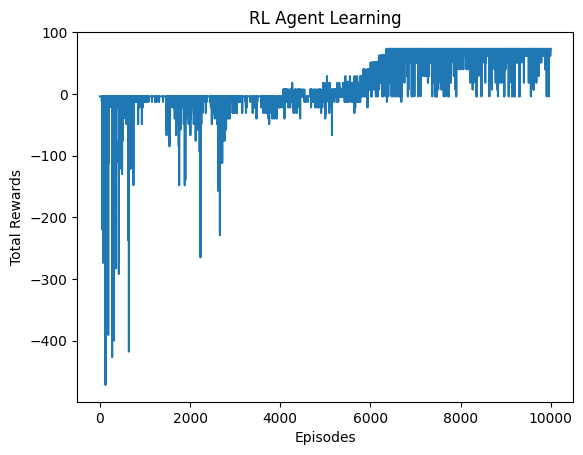

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards")
plt.title("RL Agent Learning")
plt.show()


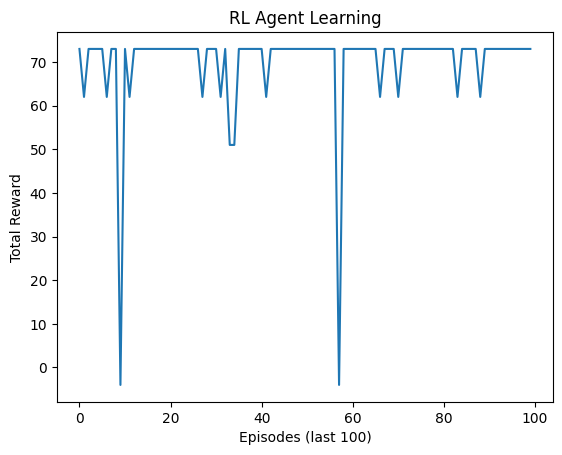

In [ ]:
import matplotlib.pyplot as plt

last_1000_rewards = rewards_per_episode[-100:]

plt.plot(last_1000_rewards)
plt.xlabel("Episodes (last 100)")
plt.ylabel("Total Reward")
plt.title("RL Agent Learning")
plt.show()


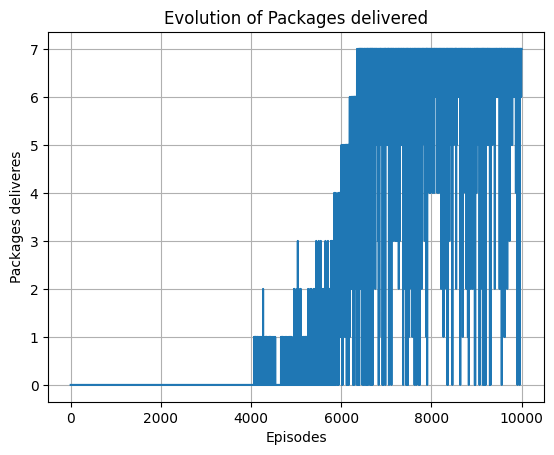

In [ ]:
import matplotlib.pyplot as plt

plt.plot(entregas_historial)
plt.xlabel("Episodes")
plt.ylabel("Packages deliveres")
plt.title("Evolution of Packages delivered")
plt.grid(True)
plt.show()


In [ ]:
# Avarage points per episode
promedio_puntos = sum(rewards_per_episode) / len(rewards_per_episode)

# Avarage packages delivered per episode
promedio_entregas = sum(entregas_historial) / len(entregas_historial)

print(f"Avarage points per episode: {promedio_puntos:.2f}")
print(f"Avarage packages delivered per episode: {promedio_entregas:.2f}")


Avarage points per episode: 23.24
Avarage packages delivered per episode: 2.62


In [ ]:
import heapq

def heuristica(a, b):
    """ Distancia Manhattan entre dos puntos """
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star(grid_size, start, goal, obstacles):
    """ Algoritmo A* para encontrar el camino más corto en una cuadrícula """
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristica(start, goal)}

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return path

        neighbors = [(current[0] + dx, current[1] + dy) for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]]

        for neighbor in neighbors:
            if 0 <= neighbor[0] < grid_size and 0 <= neighbor[1] < grid_size and neighbor not in obstacles:
                tentative_g_score = g_score[current] + 1

                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristica(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return []

# Enviroment
grid_size = 10
pickup_point = (9, 4)
delivery_point = (8, 8)
start=(1,1)
env.obstacles

# Execute A*
ruta_optimaS = a_star(grid_size, start, pickup_point, env.obstacles)
print("Shortest path from start point to pickup point by A*:", ruta_optimaS)
print(f"Steps using A*: {len(ruta_optimaS)}")
ruta_optima = a_star(grid_size, pickup_point, delivery_point, env.obstacles)
print("Shortest path from pickup point to delivery point by A*:", ruta_optima)
print(f"Steps using A*: {len(ruta_optima)}")
ruta_heuristica = len(ruta_optimaS) + len(ruta_optima) -2 #subtract start point and double pickup point
print("Total steps: ", ruta_heuristica)
pasos_heu = (100 - ruta_heuristica ) / 10 #steps it takes to go from pikup to delivery and back
print("RL deliveries:", env.delivered_packages)
print("Heuristis deliveries:", int(pasos_heu))
pasos_RL = env.delivered_packages
if pasos_RL < pasos_heu:
        print("Heuristic is more eficient")
else:
        print("RL is more eficient.")



Shortest path from start point to pickup point by A*: [(1, 1), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4)]
Steps using A*: 12
Shortest path from pickup point to delivery point by A*: [(9, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8)]
Steps using A*: 6
Total steps:  16
RL deliveries: 7
Heuristis deliveries: 8
Heuristic is more eficient


## Visualization with Animation

In [ ]:
print( trayectoria_ultimo_ep)


[(1, 1), (2, 1), (2, 2), (3, 2), (4, 2), (4, 3), (5, 3), (6, 3), (6, 4), (7, 4), (8, 4), (9, 4), (9, 4), (9, 5), (9, 6), (8, 6), (8, 7), (8, 8), (8, 8), (8, 7), (8, 6), (9, 6), (9, 5), (9, 4), (9, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 8), (8, 7), (8, 6), (9, 6), (9, 5), (9, 4), (9, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 8), (8, 7), (8, 6), (9, 6), (9, 5), (9, 4), (9, 4), (9, 5), (8, 5), (8, 6), (8, 7), (8, 8), (8, 8), (8, 7), (8, 6), (9, 6), (9, 5), (9, 4), (9, 4), (9, 4), (9, 4), (9, 5), (8, 5), (8, 6), (8, 7), (8, 8), (8, 8), (8, 7), (8, 7), (8, 6), (8, 5), (9, 5), (9, 4), (9, 4), (9, 5), (8, 5), (8, 6), (8, 7), (8, 8), (8, 8), (8, 7), (8, 6), (9, 6), (9, 5), (9, 4), (9, 4), (9, 5), (9, 6), (9, 7), (8, 7), (8, 8), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (8, 3), (8, 2), (8, 1)]


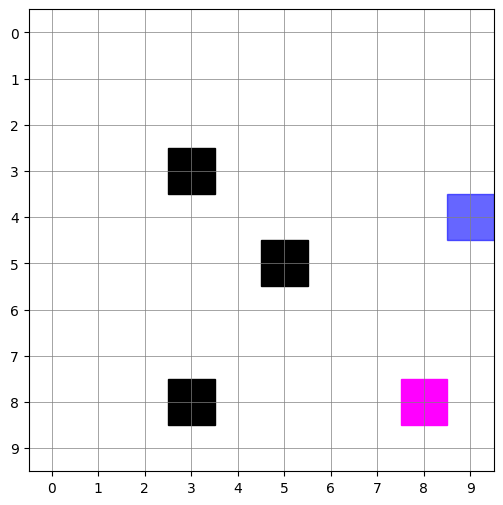

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML


if not hasattr(env, "trayectoria_ultimo_ep") or len(env.trayectoria_ultimo_ep) == 0:
    raise ValueError("No se ha registrado la trayectoria del último episodio.")

trayectoria_ultimo_ep = env.trayectoria_ultimo_ep  # positions list
grid_size = env.grid_size  # grid size

# create figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-0.5, grid_size - 0.5)
ax.set_ylim(grid_size - 0.5, -0.5)


ax.set_xticks(np.arange(0, grid_size, 1))
ax.set_yticks(np.arange(0, grid_size, 1))
ax.set_xticklabels(np.arange(0, grid_size, 1), fontsize=10, color='black')
ax.set_yticklabels(np.arange(0, grid_size, 1), fontsize=10, color='black')
ax.grid(which='both', color='gray', linestyle='-', linewidth=0.5)

# Draw obstacles
for obs in env.obstacles:
    ax.add_patch(plt.Rectangle((obs[0] - 0.5, obs[1] - 0.5), 1, 1, color="black"))

# Draw pickup point
pickup_x, pickup_y = env.pickup_point
ax.add_patch(plt.Rectangle((pickup_x - 0.5, pickup_y - 0.5), 1, 1, color="blue", alpha=0.6))

# Draw delivery point
delivery_x, delivery_y = env.delivery_point
ax.add_patch(plt.Rectangle((delivery_x - 0.5, delivery_y - 0.5), 1, 1, color="magenta", alpha=1))

# Initialize robot
robot, = ax.plot([], [], "ro", markersize=10)  # "ro" = red circle (robot)

# Start animation
def init():
    robot.set_data([], [])
    return robot,

# Update animation
def update(frame):
    # Get coordenates for actual frame
    x, y = trayectoria_ultimo_ep[frame]

    # Update position
    robot.set_data([x], [y])

    return robot,  # Return update

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(trayectoria_ultimo_ep), init_func=init, interval=1000, repeat=False)

HTML(ani.to_jshtml())
